# KG Normalization Analysis

Analysis of LLM normalization results from the KG experiment pipeline.
Data exported from `kg_experiment_v2.ipynb`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
df_llm = pd.read_csv(Path("llm_normalization_results.csv"))
threshold = 0.6  # similarity threshold used during pipeline run
print(f"Loaded {len(df_llm)} LLM check results")
print(f"  Merges: {df_llm['should_merge'].sum()}, Non-merges: {(~df_llm['should_merge']).sum()}")
print(f"  Similarity range: {df_llm['similarity'].min():.3f} - {df_llm['similarity'].max():.3f}")

Loaded 583 LLM check results
  Merges: 29, Non-merges: 554
  Similarity range: 0.600 - 0.911


In [3]:
# Per-paragraph stats: how LLM checks grow as master graph grows
para_stats = df_llm.groupby("paragraph_idx").agg(
    llm_checks=("should_merge", "count"),
    merges=("should_merge", "sum"),
    min_sim=("similarity", "min"),
    max_sim=("similarity", "max"),
    mean_sim=("similarity", "mean"),
)
para_stats["merges"] = para_stats["merges"].astype(int)
print("LLM checks per paragraph (shows scaling as graph grows):")
print(para_stats.to_string())

print(f"\n--- Threshold analysis ---")
print(f"Current threshold: {threshold}")
merges = df_llm[df_llm["should_merge"]]
non_merges = df_llm[~df_llm["should_merge"]]
print(f"Total: {len(df_llm)} checks ({len(merges)} merges, {len(non_merges)} non-merges)")

if not merges.empty:
    print(f"\nMerge similarities:    min={merges['similarity'].min():.3f}, max={merges['similarity'].max():.3f}, mean={merges['similarity'].mean():.3f}")
print(f"Non-merge similarities: min={non_merges['similarity'].min():.3f}, max={non_merges['similarity'].max():.3f}, mean={non_merges['similarity'].mean():.3f}")

print(f"\nThreshold sweep \u2014 checks remaining (merges kept):")
for t in [0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85]:
    above = df_llm[df_llm["similarity"] >= t]
    merges_kept = above["should_merge"].sum()
    total_merges = merges["should_merge"].sum() if not merges.empty else 0
    pct = len(above) / len(df_llm) * 100
    print(f"  {t:.2f}: {len(above):3d} checks ({pct:4.0f}%), {int(merges_kept)}/{int(total_merges)} merges kept")

LLM checks per paragraph (shows scaling as graph grows):
               llm_checks  merges   min_sim   max_sim  mean_sim
paragraph_idx                                                  
2                       1       0  0.625771  0.625771  0.625771
3                       4       1  0.633715  0.645830  0.639547
4                       7       0  0.617789  0.799972  0.662998
5                       3       0  0.613192  0.640658  0.628965
6                       5       3  0.657818  0.798482  0.712165
7                      16       0  0.605125  0.732813  0.651927
9                       8       1  0.630716  0.762090  0.665559
10                      7       1  0.614047  0.746282  0.663150
11                     11       1  0.600026  0.768170  0.669708
12                     11       2  0.602218  0.774110  0.670179
13                      6       1  0.604130  0.697186  0.643128
15                      7       0  0.617979  0.670571  0.642298
16                      7       0  0.623318  0.

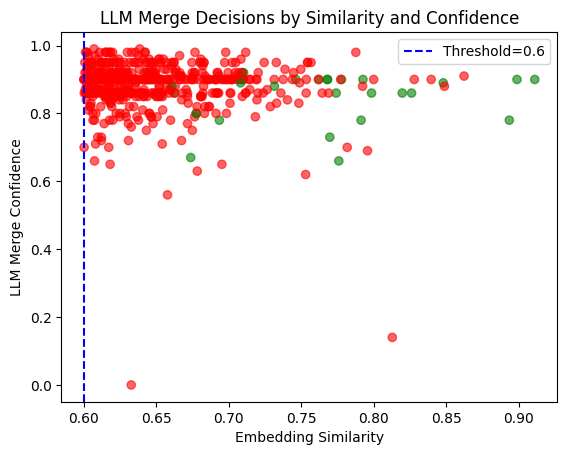

In [4]:
plt.scatter(df_llm["similarity"], df_llm["confidence"], c=df_llm["should_merge"].map({True: "green", False: "red"}), alpha=0.6)
plt.xlabel("Embedding Similarity")
plt.ylabel("LLM Merge Confidence")
plt.title("LLM Merge Decisions by Similarity and Confidence")
plt.axvline(threshold, color="blue", linestyle="--", label=f"Threshold={threshold}")
plt.legend()
plt.show()

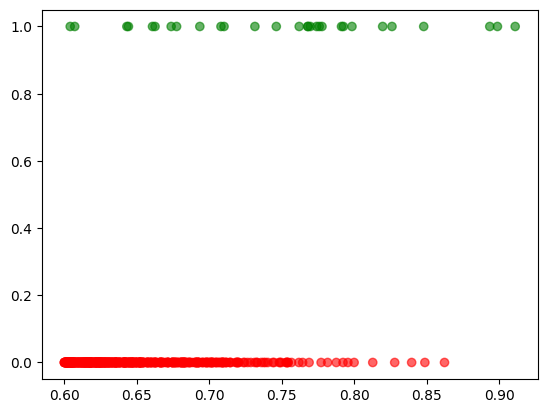

In [5]:
plt.scatter(df_llm["similarity"], df_llm["should_merge"].map({True: 1, False: 0}), c=df_llm["should_merge"].map({True: "green", False: "red"}), alpha=0.6)

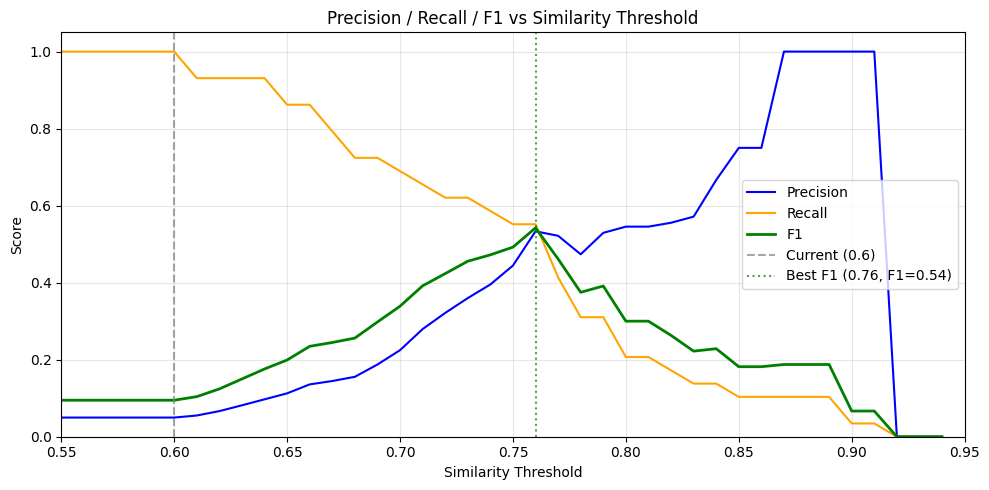

In [6]:
# Precision, Recall, F1 vs similarity threshold
# Treating LLM should_merge as ground truth:
#   At threshold t: candidates = pairs with similarity >= t
#   TP = merges above t, FP = non-merges above t, FN = merges below t

thresholds = np.arange(0.55, 0.95, 0.01)
precision, recall, f1 = [], [], []

total_merges = df_llm["should_merge"].sum()

for t in thresholds:
    above = df_llm[df_llm["similarity"] >= t]
    tp = above["should_merge"].sum()
    fp = len(above) - tp
    fn = total_merges - tp

    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0

    precision.append(p)
    recall.append(r)
    f1.append(f)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresholds, precision, label="Precision", color="blue")
ax.plot(thresholds, recall, label="Recall", color="orange")
ax.plot(thresholds, f1, label="F1", color="green", linewidth=2)
ax.axvline(threshold, color="gray", linestyle="--", alpha=0.7, label=f"Current ({threshold})")

best_idx = np.argmax(f1)
ax.axvline(thresholds[best_idx], color="green", linestyle=":", alpha=0.7,
           label=f"Best F1 ({thresholds[best_idx]:.2f}, F1={f1[best_idx]:.2f})")

ax.set_xlabel("Similarity Threshold")
ax.set_ylabel("Score")
ax.set_title("Precision / Recall / F1 vs Similarity Threshold")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0.55, 0.95)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

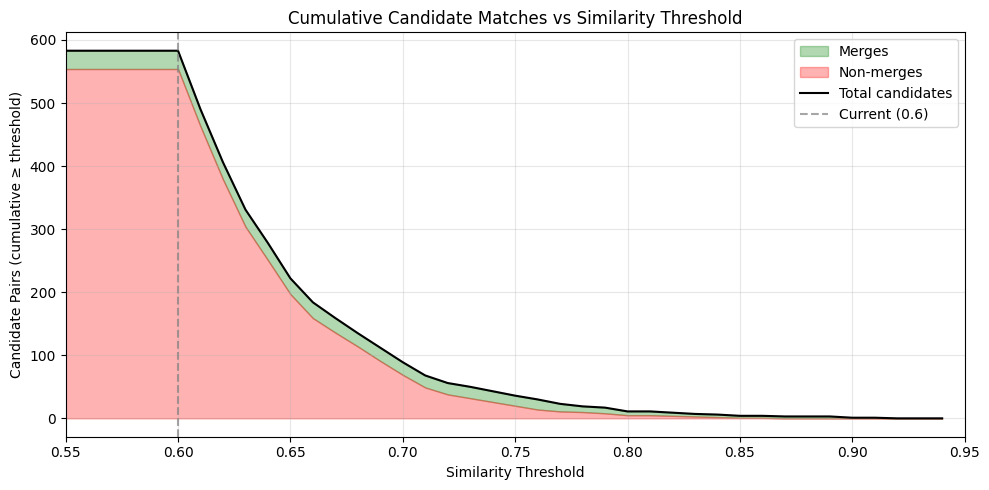

In [7]:
# Cumulative count of potential matches vs similarity threshold
# At each threshold: how many candidate pairs have similarity >= t

thresholds_cum = np.arange(0.55, 0.95, 0.01)
counts_all = [len(df_llm[df_llm["similarity"] >= t]) for t in thresholds_cum]
counts_merge = [df_llm.loc[df_llm["similarity"] >= t, "should_merge"].sum() for t in thresholds_cum]
counts_no_merge = [c - m for c, m in zip(counts_all, counts_merge)]

fig, ax = plt.subplots(figsize=(10, 5))
ax.fill_between(thresholds_cum, counts_no_merge, counts_all, alpha=0.3, color="green", label="Merges")
ax.fill_between(thresholds_cum, 0, counts_no_merge, alpha=0.3, color="red", label="Non-merges")
ax.plot(thresholds_cum, counts_all, color="black", linewidth=1.5, label="Total candidates")
ax.axvline(threshold, color="gray", linestyle="--", alpha=0.7, label=f"Current ({threshold})")

ax.set_xlabel("Similarity Threshold")
ax.set_ylabel("Candidate Pairs (cumulative \u2265 threshold)")
ax.set_title("Cumulative Candidate Matches vs Similarity Threshold")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0.55, 0.95)
plt.tight_layout()
plt.show()

In [8]:
df_llm["should_merge"].sum()

np.int64(29)

In [9]:
df_llm[df_llm["should_merge"]==True].sort_values("similarity", ascending=False)

,paragraph_idx,page,entity1_name,entity2_name,similarity,should_merge,confidence,reasoning
332,43,338,Rubicon,River Rubicon,0.911060,True,0.90,Both entries refer to the same geographical fe...
339,46,340,the Rubicon,Rubicon,0.898824,True,0.90,Both entries refer to the same geographic feat...
185,29,330,Roman army,Roman military power,0.893531,True,0.78,Both entries describe the Roman military force...
187,29,330,provinces,Roman provinces,0.847970,True,0.89,Both entries describe the same concept: the ad...
128,22,327,Carthage,Carthaginians,0.826082,True,0.86,The two mentions refer to the same underlying ...
261,36,333,Rome’s allies,allies,0.819649,True,0.86,Both entity descriptions refer to the same con...
15,6,321,Etruscan,Etruscans,0.798482,True,0.86,Both entries refer to the same historical grou...
450,66,348,Greek background,Greek civilization,0.792571,True,0.90,Both mentions refer to the same cultural conce...
451,66,348,Greeks,Greeks of the Hellenistic era,0.791263,True,0.78,Both mentions refer to the same collective gro...
536,79,356,Roman pantheon,Graeco-Roman gods,0.777803,True,0.90,Both entries refer to the same concept: the co...


In [10]:
df_llm[df_llm["should_merge"]==False].sample(20, random_state=42).sort_values("similarity", ascending=False)

,paragraph_idx,page,entity1_name,entity2_name,similarity,should_merge,confidence,reasoning
111,20,326,western Mediterranean,Roman Mediterranean,0.714467,False,0.87,The two names refer to different regional conc...
93,17,325,fifth century BC,tenth century BC,0.711681,False,0.98,The two entities are temporal references to di...
177,28,329,third Punic War,Punic Wars,0.684534,False,0.90,The Third Punic War is a specific conflict (14...
489,68,350,Babylon,Rome,0.654892,False,0.96,Babylon and Rome are distinct historical citie...
395,56,345,Romania,Europe,0.649790,False,0.93,These are distinct geographical entities: Roma...
7,4,318,Etruria,Asia,0.647487,False,0.95,Etruria is the region in central Italy inhabit...
149,23,327,Spain,Sardinia,0.645070,False,0.96,Spain and Sardinia are distinct geographic reg...
96,18,326,central Italy,Etruria,0.642729,False,0.90,Etruria is a specific historical region within...
202,29,330,Roman army,Roman Republic,0.641934,False,0.98,The Roman army (military organization) and the...
82,15,324,plebeian assembly,Roman Senate,0.641588,False,0.92,The 'plebeian assembly' (an assembly of the pl...
